# Digit Classification: Principal Components Analysis and State Vector Classifier

<br />
<br />
<br />

### Table of Contents

* Introduction

* Load Data

* Classification Task
 * Principal Components Analysis
 * State Vector Classifier
 * Subspace Projection: Visualizing Principal Components
 * Assessing the Model
 * Back-Projection Error
 
* Five-Component PCA

* Impact of Number of Components
 * Impact on Accuracy and Confusion Matrix
 * Impact on Back-Projection Error

<br />
<br />
<br />


# Introduction

This notebook will illustrate the use of principal components analysis (PCA) to reduce the dimensionality of a data set, and combine PCA with a state vector classifier (SVC) to classify digits using this lower-dimensional representation.

The data set utilized is a [handwritten digits data set](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) provided by the [UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets.html) repository and consists of 8x8 optical scans of handwritten digits, together with labels of the correct digit.

For a $d$-dimensional input vector, PCA attempts to find a lower-dimensional representation that minimizes the amount of variance lost by lowering the dimensionality. 

In [1]:
%matplotlib inline

# numbers
import numpy as np
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns

# utils
import os, re
from pprint import pprint

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# learn you some machines
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Load Data

The data set consists of 8x8 bitmap images of handwritten digits, with a file for a training set and a file for a testing set.

In [3]:
testing_df = pd.read_csv('data/optdigits/optdigits.tes',header=None)
X_testing,  y_testing  = testing_df.loc[:,0:63],  testing_df.loc[:,64]

training_df = pd.read_csv('data/optdigits/optdigits.tra',header=None)
X_training, y_training = training_df.loc[:,0:63], training_df.loc[:,64]

print X_training.shape
print y_training.shape

(3823, 64)
(3823,)


[[ 0  1  6 15 12  1  0  0]
 [ 0  7 16  6  6 10  0  0]
 [ 0  8 16  2  0 11  2  0]
 [ 0  5 16  3  0  5  7  0]
 [ 0  7 13  3  0  8  7  0]
 [ 0  4 12  0  1 13  5  0]
 [ 0  0 14  9 15  9  0  0]
 [ 0  0  6 14  7  1  0  0]]


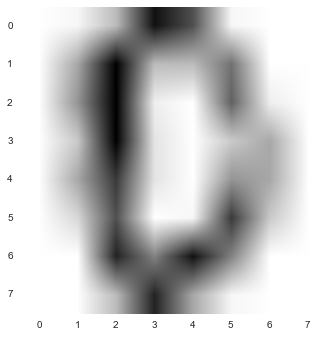

In [4]:
mat = X_training.loc[0,:].reshape(8,8)
print mat
plt.imshow(mat)
gca().grid(False)
plt.show()

To perform PCA it's best to normalize our data so it has a mean of 0 and a variance of 1:

In [5]:
def get_normed_mean_cov(X):
    X_std = StandardScaler().fit_transform(X)
    X_mean = np.mean(X_std, axis=0)
    
    ## Automatic:
    #X_cov = np.cov(X_std.T)
    
    # Manual:
    X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (X_std.shape[0]-1)
    
    return X_std, X_mean, X_cov

X_std, X_mean, X_cov = get_normed_mean_cov(X_training)
X_std_validation, _, _ = get_normed_mean_cov(X_testing)

# Classification Task

## Principal Components Analysis

We proceed by using the PCA object provided by scikit-learn, and pass it a number of components. Using it is very straightforward: we create it, we fit it to our standardized input data, then we transform our inputs into the reduced dimension space:

In [6]:
# Make PCA
pca2 = PCA(n_components=2, whiten=True)
pca2.fit(X_std)
X_red = pca2.transform(X_std)

## State Vector Classifier

Now that we have reduced the number of dimensions from 64 to 2, we can pass the the reduced dimensional data to a state vector classifier, and fit the reduced inputs to the desired system response.

In [7]:
# Make SVC
linclass2 = SVC()
linclass2.fit(X_red,y_training)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Subspace Projection: Visualizing Principal Components

Because we used a 2-component PCA, we can project the original data from high-dimensional space into lower-dimensional principal component space (the subspace projection). We can color each data point by its corresponding digit class, and in this way get a visual sense of how well these classes have been separated in principal component space. 

(Remember: we're asking a lot of our PCA model - reducing 64 dimensions to 2 is no mean feat!)

In [8]:
# To color each point by the digit it represents,
# create a color map with 10 elements (10 RGB values).
# Then, use the system response (y_training), which conveniently
# is a digit from 0 to 9.
def get_cmap(n):
    #colorz = plt.cm.cool
    colorz = plt.get_cmap('Set1')
    return [ colorz(float(i)/n) for i in range(n)]

colorz = get_cmap(10)
colors = [colorz[yy] for yy in y_training]

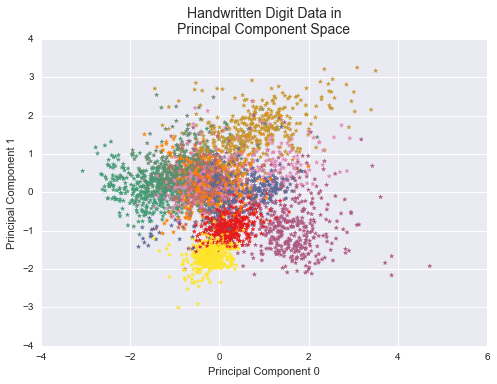

In [9]:
scatter(X_red[:,0], X_red[:,1], 
        color=colors, marker='*')
xlabel("Principal Component 0")
ylabel("Principal Component 1")
title("Handwritten Digit Data in\nPrincipal Component Space",size=14)
show()

## Assessing the Model

Now that we've reduced the input dimensionality and built a classifier model to classify digits based on the lower-dimensional representation, we can use the validation set to see how well the model does at classifying handwritten digits. First we transform our high-dimensional validation data to low-dimensional principal component space, then we feed the low-dimensional input to the SVC.

In [10]:
# Now see how good it is:
# Use the PCA to fit the validation data,
# then use the classifier to classify digits.
X_red_validation = pca2.transform(X_std_validation)
yhat_validation = linclass2.predict(X_red_validation)

y_validation = y_testing

Next, we visualize the results using a confusion matrix: this visualizes the predicted class on the y-axis and the actual class on the x-axis. All of our correct digits will line up on the diagonal, while an examination of other hotspots in the confusion matrix will reveal any digits that are commonly mistaken for others (for example, we see that our model does a pretty terrible job of identifying the digit 5).

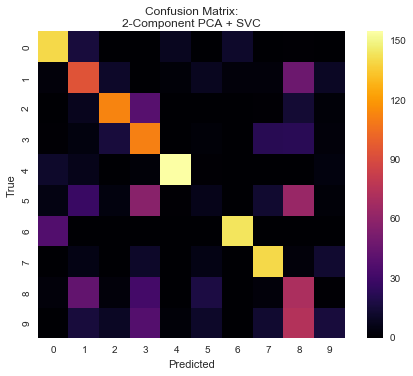

In [11]:
pca2_cm = confusion_matrix(y_validation,yhat_validation)
sns.heatmap(pca2_cm, square=True, cmap='inferno')
title('Confusion Matrix:\n2-Component PCA + SVC')
ylabel('True')
xlabel('Predicted')
show()

Given the amount of information we're trying to cram into our two components, we would expect this model to do a pretty dismal job, and indeed it does. But it does better than we might expect a 2-component model to do.

In [12]:
total = pca2_cm.sum(axis=None)
correct = pca2_cm.diagonal().sum()
print "2-Component PCA Accuracy: %0.2f %%"%(100.0*correct/total)

2-Component PCA Accuracy: 55.20 %


## Back-Projection Error

Once we analyze results, it is useful to quantify the amount of variance in the original data that was lost by the PCA transformation. To do this we can use either the explained variance, or we can back-project the lower-dimensional representation to higher-dimensional space and compare the original to the back-projected high-dimensional input vectors. If we do the latter, we see the error is rather large:

In [13]:
# MSE associated with back-projection:
X_orig = X_std
X_hat = pca2.inverse_transform( pca2.transform(X_orig) )

mse = ((X_hat - X_orig)**2).mean(axis=None)
print mse

0.754124931663


This is a pretty significant difference - MSE should be somewhere between 0 (no error) and 1 (all error). Think of it like having an $R^2$ value of 0.25.

# Five-Component PCA

To increase the accuracy of the SVC, we need to add more principal components. Performing a 5-component PCA leads to a big improvement in the model's performance:

In [14]:
# Make PCA
pca5 = PCA(n_components=5, whiten=True)
pca5.fit(X_std)
X_red = pca5.transform(X_std)

# Make SVC
linclass5 = SVC()
linclass5.fit(X_red,y_training)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
# Use the PCA to fit the validation data,
# then use the classifier to classify digits.
X_red_validation = pca5.transform(X_std_validation)
yhat_validation = linclass5.predict(X_red_validation)

y_validation = y_testing

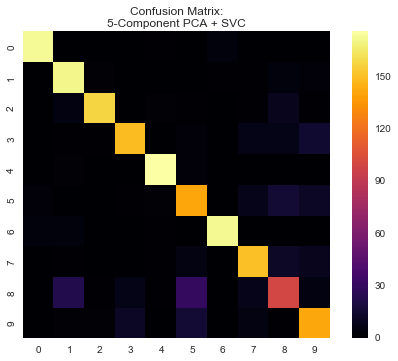

In [16]:
pca5_cm = confusion_matrix(y_validation,yhat_validation)
sns.heatmap(pca5_cm, square=True, cmap='inferno')
title('Confusion Matrix:\n5-Component PCA + SVC')
show()

In [17]:
total = pca5_cm.sum(axis=None)
correct = pca5_cm.diagonal().sum()
print "5-Component PCA Accuracy: %0.2f %%"%(100.0*correct/total)

5-Component PCA Accuracy: 85.20 %


# Impact of Number of Components

Let's take a look at the impact of the number of components on both the PCA and the SVC. Start with the most important thing: whether the predictions are correct. The impact of number of principal components can be plotted against the percent accuracy of the classifier. Next, the back-projection error introduced by PCA will be analyzed as a function of number of components. We will show that this is nearly identical to the explained variance of the PCA analysis.

We'll do this by looping over a number of components. For each specified number of principal components, we will construct a PCA model and fit it, and build an SVC model and fit it, and we'll store the percent accuracy of the SVC and the back-projection error of the PCA model.

In [24]:
def pca_mse_accuracy(n):
    """
    Creates a PCA model with n components,
    reduces the dimensionality of the validation data set,
    then computes two error metrics:
    * Percent correct predictions using linear classifier
    * Back-projection error (MSE of back-projected X minus original X)
    """
    
    
    X_std, _, _ = get_normed_mean_cov(X_training)
    X_std_validation, _, _ = get_normed_mean_cov(X_testing)
    
    #########
    # Start by making PCA/SVC
    # Train on training data
    
    # Make PCA
    pca = PCA(n_components=n, whiten=True)
    pca.fit(X_std)
    X_red = pca.transform(X_std)

    # Make SVC
    linclass = SVC()
    linclass.fit(X_red,y_training)

    
    ########
    # Now transform validation data
    
    # Transform inputs and feed them to linear classifier
    y_validation = y_testing
    X_red_validation = pca.transform(X_std_validation)
    yhat_validation = linclass.predict(X_red_validation)
    
    # Evaluate confusion matrix for predictions
    cm = confusion_matrix(y_validation,yhat_validation)
    total = cm.sum(axis=None)
    correct = cm.diagonal().sum()
    accuracy = 1.0*correct/total
    
    
    # MSE associated with back-projection:
    X_orig = X_std
    X_hat = pca.inverse_transform( pca.transform(X_orig) )
    mse = ((X_hat - X_orig)**2).mean(axis=None)
    
    
    
    
    return mse, accuracy


mses = []
accuracies = []
N = 33
for i in range(1,N):
    m, a = pca_mse_accuracy(i)
    
    print "%d-component PCA: MSE = %0.4g, Accuracy = %0.2f"%(i,m,a*100.0)
    
    mses.append((i,m))
    accuracies.append((i,a))
    
mses = np.array(mses)
accuracies = np.array(accuracies)

1-component PCA: MSE = 0.856, Accuracy = 35.84
2-component PCA: MSE = 0.7541, Accuracy = 55.20
3-component PCA: MSE = 0.6802, Accuracy = 72.95
4-component PCA: MSE = 0.6249, Accuracy = 83.25
5-component PCA: MSE = 0.5768, Accuracy = 85.09
6-component PCA: MSE = 0.5317, Accuracy = 87.53
7-component PCA: MSE = 0.4944, Accuracy = 89.65
8-component PCA: MSE = 0.4617, Accuracy = 92.04
9-component PCA: MSE = 0.4341, Accuracy = 93.10
10-component PCA: MSE = 0.4086, Accuracy = 94.16
11-component PCA: MSE = 0.3843, Accuracy = 93.93
12-component PCA: MSE = 0.361, Accuracy = 94.44
13-component PCA: MSE = 0.3389, Accuracy = 94.38
14-component PCA: MSE = 0.3187, Accuracy = 95.99
15-component PCA: MSE = 0.2997, Accuracy = 96.10
16-component PCA: MSE = 0.2814, Accuracy = 95.77
17-component PCA: MSE = 0.2635, Accuracy = 95.99
18-component PCA: MSE = 0.2461, Accuracy = 96.55
19-component PCA: MSE = 0.2304, Accuracy = 96.44
20-component PCA: MSE = 0.2152, Accuracy = 96.66
21-component PCA: MSE = 0.2014,

Obviously this is only one set of parameters, and the problem could be solved with many variations in the models used. However, this gives a sense of how the accuracy of the model increases as we add additional components.

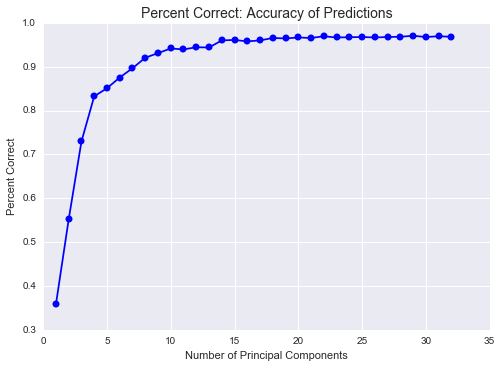

In [25]:
# Now plot the accuracy
plt.plot(accuracies[:,0],accuracies[:,1],'bo-')
plt.title("Percent Correct: Accuracy of Predictions",size=14)
plt.xlabel("Number of Principal Components")
plt.ylabel("Percent Correct")
plt.show()

## Impact on Back-Projection Error

back-projection analysis with explained variance.

In [36]:
Nmax = 64

pcafull = PCA(n_components=Nmax, whiten=True)
_ = pcafull.fit(X_std)
explained_var_sum = pcafull.explained_variance_.sum()

explained_var = np.cumsum(pcafull.explained_variance_[:N])
explained_var /= explained_var_sum

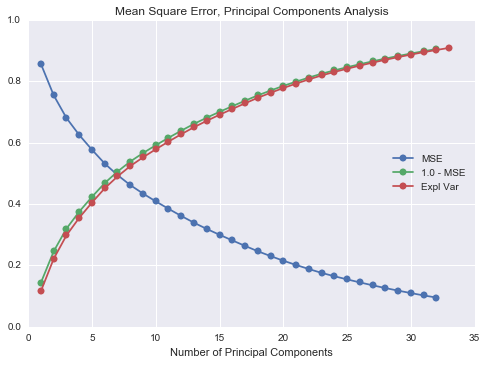

In [38]:
plot(mses[:,0],mses[:,1],'-o',label='MSE')
plot(mses[:,0],1.0-mses[:,1],'-o',label='1.0 - MSE')
plot(range(1,len(explained_var)+1),explained_var,'-o',label='Expl Var')

xlabel('Number of Principal Components')
ylabel('')
title('Mean Square Error, Principal Components Analysis')

legend(loc='best')
show()

While the explained variance isn't exactly $1 - MSE$, it's pretty close. Since the explained variance is a lot easier to get anyway, it's the better of the two to use to measure how much variance in the original dataset is retained when reducing to $N$ principal components.

# Conclusion

In this notebook we utilized principal components analysis (PCA) to reduce the dimensionality of the handwritten digits data set, and passed this to a state vector classifier (SVC) to classify which digit was written. The state vector classifier achieved 83% accuracy with only four principal components; the image data set lends itself well to dimensionality reduction. In another notebook we analyze the reduced dimensional subspace and back-project it to look at the topology for different clusters (and what the topology looks like in areas where there are no data!).